# Tutorial 7: 2D Anisotropic Diffusion, non coercive case

In this tutorial, we consider the study and analysis of the eigenvalue problem associated to the following anisotropic diffusion operator
$$
    - \nabla \cdot \mathbf{b} \otimes \mathbf{b} \nabla \phi = \omega^2 \phi
$$
where $\mathbf{b} = (\iota, 1)$ is the normalized vector of the magnetic field.

In fact, the original problem is 3D and the iota profile is given as

$$
    \iota(r) = 0.47262 + 0.32392 r + 0.49604 r^2 + 5.3991 . 10^{-6} r^3 - 3.165 . 10^{-5} r^4 + 4.7963 . 10^{-5} r^5 - 2.2824 . 10^{-5} r^6
$$

which is the LHD-$\iota$-profile. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from vale import construct_model
import numpy as np
import os
import clapp.common.utils      as clapp_utils

# ... initializing Clapp
clapp_utils.initialize()
# ...

# ...
def construct_pde(filename, mapping, discretization):
    # ... clean input directory. needed for Fortran
    cmd = "rm -rf input"
    os.system(cmd)
    # ...

    # ... creates discretization parameters
    from clapp.disco.parameters.bspline import BSpline

    bspline_params = BSpline(discretization["n_elements"], \
                             discretization["degrees"], \
                             bc_min=[1,1], \
                             bc_max=[1,1])
    # ...

    # ... create a context from discretization
    from clapp.fema.context        import Context

    context = Context(dirname="input", \
                      discretization_params=bspline_params)
    # ...

    # ...
    pde = construct_model(filename, backend="clapp", \
                          context=context, mapping=mapping)
    # ...
    
    # ... clean input directory
    cmd = "rm -rf input"
    os.system(cmd)
    # ...
    
    return pde
# ...

We use **CAID** to create the geometry, then convert it to the *mapping* object from *CLAPP*

In [2]:
# ... creates a unit line geometry using CAID
from caid.cad_geometry import square
geometry = square()
# ...
    
# ...
from clapp.spl.mapping import Mapping
mapping = Mapping(geometry=geometry)
# ...

The following flag allows to assemble the involved matrices

In [3]:
with_matrix = False

The following function allows us to extract the modes we are interesting in

In [4]:
def mode(i,j):
    t1 = i * 2 * np.pi / nx
    t2 = j * 2 * np.pi / ny

    u = 0.5 + i * 2. / nx
    v = 0.5 + j * 2. / ny

    x = float(mapping.evaluate([u],[v])[0,:,:][0,0])
    y = float(mapping.evaluate([u],[v])[1,:,:][0,0])

    g = f_a(x,y,t1,t2)/f_c(x,y,t1,t2);
    g = g / (4 * np.pi**2)
    
    return g

## Constants coefficients case

Now taking the given radius $r = 0.9$ we get

$$
\mathbf{b} = (b_1,b_2)^\top = (1.1659397624413860850012270020670, 1. )^\top
$$

### Linear B-Splines

Convergence over a grid $128 \times 128$

| mode   |   approximated |    exact |   absolute error | relative error   |
|:-------|---------------:|---------:|-----------------:|:-----------------|
| (-2,2) |       0.117736 | 0.110144 |      0.00759231  | 0.0689307690246  |
| (-1,1) |       0.02801  | 0.027536 |      0.000473954 | 0.0172121386494  |
| (0,0)  |       0        | 0        |      0           |                  |
| (1,-1) |       0.02801  | 0.027536 |      0.000473954 | 0.0172121386494  |
| (2,-2) |       0.117736 | 0.110144 |      0.00759231  | 0.0689307690246  |

Convergence over a grid $256 \times 256$

| mode   |   approximated |     exact |   absolute error | relative error   |
|:-------|---------------:|----------:|-----------------:|:-----------------|
| (-6,5) |      0.137052  | 0.0290025 |      0.108049    | 3.72552219632    |
| (-5,4) |      0.162007  | 0.113058  |      0.0489488   | 0.432953432604   |
| (-2,2) |      0.11204   | 0.110144  |      0.00189581  | 0.0172121386494  |
| (-1,1) |      0.0276545 | 0.027536  |      0.000118453 | 0.00430175091897 |
| (0,0)  |      0         | 0         |      0           |                  |
| (1,-1) |      0.0276545 | 0.027536  |      0.000118453 | 0.00430175091897 |
| (2,-2) |      0.11204   | 0.110144  |      0.00189581  | 0.0172121386494  |
| (5,-4) |      0.162007  | 0.113058  |      0.0489488   | 0.432953432604   |
| (6,-5) |      0.137052  | 0.0290025 |      0.108049    | 3.72552219632    |

Convergence over a grid $512 \times 512$

| mode   |   approximated |      exact |   absolute error | relative error   |
|:-------|---------------:|-----------:|-----------------:|:-----------------|
| (-8,7) |      0.118607  | 0.0261076  |      0.0924999   | 3.54303279553    |
| (-7,6) |      0.0523186 | 1.9022e-05 |      0.0522996   | 2749.42297235    |
| (-6,5) |      0.0559511 | 0.0290025  |      0.0269486   | 0.929182607556   |
| (-5,4) |      0.125276  | 0.113058   |      0.0122176   | 0.108065342788   |
| (-2,2) |      0.110618  | 0.110144   |      0.000473812 | 0.00430175091897 |
| (-1,1) |      0.0275656 | 0.027536   |      2.96111e-05 | 0.0010753575555  |
| (0,0)  |      0         | 0          |      0           |                  |
| (1,-1) |      0.0275656 | 0.027536   |      2.96111e-05 | 0.0010753575555  |
| (2,-2) |      0.110618  | 0.110144   |      0.000473812 | 0.00430175091897 |
| (5,-4) |      0.125276  | 0.113058   |      0.0122176   | 0.108065342788   |
| (6,-5) |      0.0559511 | 0.0290025  |      0.0269486   | 0.929182607556   |
| (7,-6) |      0.0523186 | 1.9022e-05 |      0.0522996   | 2749.42297235    |
| (8,-7) |      0.118607  | 0.0261076  |      0.0924999   | 3.54303279553    |

### Quadratic B-Splines

Convergence over a grid $32 \times 32$

| mode   |   approximated |    exact |   absolute error | relative error    |
|:-------|---------------:|---------:|-----------------:|:------------------|
| (-4,5) |    0.178126    | 0.113058 |      0.0650682   | 0.57552959662     |
| (-2,2) |    0.11048     | 0.110144 |      0.000336159 | 0.00305199176912  |
| (-1,1) |    0.027541    | 0.027536 |      4.9645e-06  | 0.000180291399669 |
| (0,0)  |    3.39723e-15 | 0        |      3.39723e-15 |                   |
| (1,-1) |    0.027541    | 0.027536 |      4.9645e-06  | 0.000180291399669 |
| (2,-2) |    0.11048     | 0.110144 |      0.000336159 | 0.00305199176912  |
| (4,-5) |    0.178126    | 0.113058 |      0.0650682   | 0.57552959662     |

Convergence over a grid $64 \times 64$

| mode   |   approximated |      exact |   absolute error | relative error    |
|:-------|---------------:|-----------:|-----------------:|:------------------|
| (-7,8) |    0.0973301   | 0.0261076  |      0.0712226   | 2.72804448907     |
| (-6,7) |    0.0287266   | 1.9022e-05 |      0.0287076   | 1509.1753123      |
| (-5,6) |    0.0391931   | 0.0290025  |      0.0101906   | 0.351369307462    |
| (-4,5) |    0.116093    | 0.113058   |      0.00303545  | 0.0268486365773   |
| (-2,2) |    0.110164    | 0.110144   |      1.9858e-05  | 0.000180291399669 |
| (-1,1) |    0.0275363   | 0.027536   |      3.05878e-07 | 1.11082998312e-05 |
| (0,0)  |    1.35889e-14 | 0          |      1.35889e-14 |                   |
| (1,-1) |    0.0275363   | 0.027536   |      3.05878e-07 | 1.11082998312e-05 |
| (2,-2) |    0.110164    | 0.110144   |      1.9858e-05  | 0.000180291399669 |
| (4,-5) |    0.116093    | 0.113058   |      0.00303545  | 0.0268486365773   |
| (5,-6) |    0.0391931   | 0.0290025  |      0.0101906   | 0.351369307462    |
| (6,-7) |    0.0287266   | 1.9022e-05 |      0.0287076   | 1509.1753123      |
| (7,-8) |    0.0973301   | 0.0261076  |      0.0712226   | 2.72804448907     |

Convergence over a grid $128 \times 128$

| mode   |   approximated |      exact |   absolute error | relative error    |
|:-------|---------------:|-----------:|-----------------:|:------------------|
| (-9,8) |    0.115089    | 0.107268   |      0.00782114  | 0.0729120952745   |
| (-8,7) |    0.0297566   | 0.0261076  |      0.00364899  | 0.139767725163    |
| (-7,6) |    0.00155866  | 1.9022e-05 |      0.00153964  | 80.9398032605     |
| (-6,5) |    0.0295716   | 0.0290025  |      0.000569071 | 0.0196214584588   |
| (-5,4) |    0.113233    | 0.113058   |      0.000175489 | 0.00155219938851  |
| (-2,2) |    0.110145    | 0.110144   |      1.22351e-06 | 1.11082987432e-05 |
| (-1,1) |    0.027536    | 0.027536   |      1.9049e-08  | 6.91783960624e-07 |
| (0,0)  |    5.43557e-14 | 0          |      5.43557e-14 |                   |
| (1,-1) |    0.027536    | 0.027536   |      1.9049e-08  | 6.91783960624e-07 |
| (2,-2) |    0.110145    | 0.110144   |      1.22351e-06 | 1.11082987432e-05 |
| (5,-4) |    0.113233    | 0.113058   |      0.000175489 | 0.00155219938851  |
| (6,-5) |    0.0295716   | 0.0290025  |      0.000569071 | 0.0196214584588   |
| (7,-6) |    0.00155866  | 1.9022e-05 |      0.00153964  | 80.9398032605     |
| (8,-7) |    0.0297566   | 0.0261076  |      0.00364899  | 0.139767725163    |
| (9,-8) |    0.115089    | 0.107268   |      0.00782114  | 0.0729120952745   |

Convergence over a grid $256 \times 256$

| mode   |   approximated |      exact |   absolute error | relative error    |
|:-------|---------------:|-----------:|-----------------:|:------------------|
| (-9,8) |    0.107726    | 0.107268   |      0.000457582 | 0.00426577617644  |
| (-8,7) |    0.0263241   | 0.0261076  |      0.000216498 | 0.00829254817564  |
| (-7,6) |    0.000111509 | 1.9022e-05 |      9.24871e-05 | 4.86210240272     |
| (-6,5) |    0.029037    | 0.0290025  |      3.45535e-05 | 0.00119139882499  |
| (-5,4) |    0.113069    | 0.113058   |      1.07525e-05 | 9.51062356322e-05 |
| (-2,2) |    0.110144    | 0.110144   |      7.61959e-08 | 6.91783960624e-07 |
| (-1,1) |    0.027536    | 0.027536   |      1.18963e-09 | 4.3202749248e-08  |
| (0,0)  |    2.17423e-13 | 0          |      2.17423e-13 |                   |
| (1,-1) |    0.027536    | 0.027536   |      1.18963e-09 | 4.3202749248e-08  |
| (2,-2) |    0.110144    | 0.110144   |      7.61959e-08 | 6.91783960624e-07 |
| (5,-4) |    0.113069    | 0.113058   |      1.07525e-05 | 9.51062356322e-05 |
| (6,-5) |    0.029037    | 0.0290025  |      3.45535e-05 | 0.00119139882499  |
| (7,-6) |    0.000111509 | 1.9022e-05 |      9.24871e-05 | 4.86210240272     |
| (8,-7) |    0.0263241   | 0.0261076  |      0.000216498 | 0.00829254817564  |
| (9,-8) |    0.107726    | 0.107268   |      0.000457582 | 0.00426577617644  |

Convergence over a grid $512 \times 512$


| mode   |   approximated |      exact |   absolute error | relative error    |
|:-------|---------------:|-----------:|-----------------:|:------------------|
| (-9,8) |    0.107296    | 0.107268   |      2.81231e-05 | 0.000262175777066 |
| (-8,7) |    0.0261209   | 0.0261076  |      1.33541e-05 | 0.00051150157634  |
| (-7,6) |    2.47449e-05 | 1.9022e-05 |      5.72289e-06 | 0.300855814223    |
| (-6,5) |    0.0290046   | 0.0290025  |      2.14394e-06 | 7.39225375536e-05 |
| (-5,4) |    0.113059    | 0.113058   |      6.68691e-07 | 5.91458346308e-06 |
| (-2,2) |    0.110144    | 0.110144   |      4.75852e-09 | 4.3202749248e-08  |
| (-1,1) |    0.027536    | 0.027536   |      7.54528e-11 | 2.74015023274e-09 |
| (0,0)  |    8.69691e-13 | 0          |      8.69691e-13 |                   |
| (1,-1) |    0.027536    | 0.027536   |      7.54528e-11 | 2.74015023274e-09 |
| (2,-2) |    0.110144    | 0.110144   |      4.75852e-09 | 4.3202749248e-08  |
| (5,-4) |    0.113059    | 0.113058   |      6.68691e-07 | 5.91458346308e-06 |
| (6,-5) |    0.0290046   | 0.0290025  |      2.14394e-06 | 7.39225375536e-05 |
| (7,-6) |    2.47449e-05 | 1.9022e-05 |      5.72289e-06 | 0.300855814223    |
| (8,-7) |    0.0261209   | 0.0261076  |      1.33541e-05 | 0.00051150157634  |
| (9,-8) |    0.107296    | 0.107268   |      2.81231e-05 | 0.000262175777066 |

### Cubic B-Splines

Convergence over a grid $128 \times 128$

| mode   |   approximated |      exact |   absolute error | relative error    |
|:-------|---------------:|-----------:|-----------------:|:------------------|
| (-9,8) |    0.107304    | 0.107268   |      3.56812e-05 | 0.000332635554526 |
| (-8,7) |    0.0261205   | 0.0261076  |      1.29065e-05 | 0.000494357648921 |
| (-7,6) |    2.31207e-05 | 1.9022e-05 |      4.09871e-06 | 0.215471623693    |
| (-6,5) |    0.0290036   | 0.0290025  |      1.09753e-06 | 3.78425269079e-05 |
| (-5,4) |    0.113058    | 0.113058   |      2.33073e-07 | 2.06153463533e-06 |
| (-2,2) |    0.110144    | 0.110144   |      2.84705e-10 | 2.58484588968e-09 |
| (-1,1) |    0.027536    | 0.027536   |      1.78509e-12 | 6.48273409141e-11 |
| (0,0)  |   -5.77529e-14 | 0          |      5.77529e-14 |                   |
| (1,-1) |    0.027536    | 0.027536   |      1.78509e-12 | 6.48273409141e-11 |
| (2,-2) |    0.110144    | 0.110144   |      2.84705e-10 | 2.58484588968e-09 |
| (5,-4) |    0.113058    | 0.113058   |      2.33073e-07 | 2.06153463533e-06 |
| (6,-5) |    0.0290036   | 0.0290025  |      1.09753e-06 | 3.78425269079e-05 |
| (7,-6) |    2.31207e-05 | 1.9022e-05 |      4.09871e-06 | 0.215471623693    |
| (8,-7) |    0.0261205   | 0.0261076  |      1.29065e-05 | 0.000494357648921 |
| (9,-8) |    0.107304    | 0.107268   |      3.56812e-05 | 0.000332635554526 |

Convergence over a grid $256 \times 256$

| mode   |   approximated |      exact |   absolute error | relative error    |
|:-------|---------------:|-----------:|-----------------:|:------------------|
| (-9,8) |    0.107269    | 0.107268   |      4.95816e-07 | 4.62221125415e-06 |
| (-8,7) |    0.0261077   | 0.0261076  |      1.83754e-07 | 7.03833253611e-06 |
| (-7,6) |    1.90817e-05 | 1.9022e-05 |      5.96462e-08 | 0.00313563694164  |
| (-6,5) |    0.0290025   | 0.0290025  |      1.62899e-08 | 5.61674024496e-07 |
| (-5,4) |    0.113058    | 0.113058   |      3.52524e-09 | 3.11808077307e-08 |
| (-2,2) |    0.110144    | 0.110144   |      7.14034e-12 | 6.48273409141e-11 |
| (-1,1) |    0.027536    | 0.027536   |      7.73041e-13 | 2.80738385948e-11 |
| (0,0)  |   -2.31012e-13 | 0          |      2.31012e-13 |                   |
| (1,-1) |    0.027536    | 0.027536   |      7.73041e-13 | 2.80738385948e-11 |
| (2,-2) |    0.110144    | 0.110144   |      7.14034e-12 | 6.48273409141e-11 |
| (5,-4) |    0.113058    | 0.113058   |      3.52524e-09 | 3.11808077307e-08 |
| (6,-5) |    0.0290025   | 0.0290025  |      1.62899e-08 | 5.61674024496e-07 |
| (7,-6) |    1.90817e-05 | 1.9022e-05 |      5.96462e-08 | 0.00313563694164  |
| (8,-7) |    0.0261077   | 0.0261076  |      1.83754e-07 | 7.03833253611e-06 |
| (9,-8) |    0.107269    | 0.107268   |      4.95816e-07 | 4.62221125415e-06 |

Convergence over a grid $512 \times 512$

| mode   |   approximated |      exact |   absolute error | relative error    |
|:-------|---------------:|-----------:|-----------------:|:------------------|
| (-9,8) |    0.107268    | 0.107268   |      7.56669e-09 | 7.05399376257e-08 |
| (-8,7) |    0.0261076   | 0.0261076  |      2.84358e-09 | 1.08917787472e-07 |
| (-7,6) |    1.9023e-05  | 1.9022e-05 |      9.45466e-10 | 4.97037191604e-05 |
| (-6,5) |    0.0290025   | 0.0290025  |      2.72935e-10 | 9.41072945151e-09 |
| (-5,4) |    0.113058    | 0.113058   |      6.88503e-11 | 6.08982490914e-10 |
| (-2,2) |    0.110144    | 0.110144   |      3.09217e-12 | 2.80738385948e-11 |
| (-1,1) |    0.027536    | 0.027536   |      4.94702e-13 | 1.79656237829e-11 |
| (0,0)  |   -9.24046e-13 | 0          |      9.24046e-13 |                   |
| (1,-1) |    0.027536    | 0.027536   |      4.94702e-13 | 1.79656237829e-11 |
| (2,-2) |    0.110144    | 0.110144   |      3.09217e-12 | 2.80738385948e-11 |
| (5,-4) |    0.113058    | 0.113058   |      6.88503e-11 | 6.08982490914e-10 |
| (6,-5) |    0.0290025   | 0.0290025  |      2.72935e-10 | 9.41072945151e-09 |
| (7,-6) |    1.9023e-05  | 1.9022e-05 |      9.45466e-10 | 4.97037191604e-05 |
| (8,-7) |    0.0261076   | 0.0261076  |      2.84358e-09 | 1.08917787472e-07 |
| (9,-8) |    0.107268    | 0.107268   |      7.56669e-09 | 7.05399376257e-08 |


### Quartic B-Splines

Convergence over a grid $32 \times 32$

| mode   |   approximated |      exact |   absolute error | relative error    |
|:-------|---------------:|-----------:|-----------------:|:------------------|
| (-8,7) |    0.047885    | 0.0261076  |      0.0217774   | 0.834141223412    |
| (-7,6) |    0.00370117  | 1.9022e-05 |      0.00368215  | 193.573032597     |
| (-6,5) |    0.0295166   | 0.0290025  |      0.000514155 | 0.0177279718146   |
| (-5,4) |    0.113113    | 0.113058   |      5.51914e-05 | 0.000488168738898 |
| (-2,2) |    0.110144    | 0.110144   |      5.74438e-09 | 5.21533643094e-08 |
| (-1,1) |    0.027536    | 0.027536   |      3.90507e-10 | 1.41816704051e-08 |
| (0,0)  |    4.00754e-10 | 0          |      4.00754e-10 |                   |
| (1,-1) |    0.027536    | 0.027536   |      3.90507e-10 | 1.41816704051e-08 |
| (2,-2) |    0.110144    | 0.110144   |      5.74438e-09 | 5.21533643094e-08 |
| (5,-4) |    0.113113    | 0.113058   |      5.51914e-05 | 0.000488168738898 |
| (6,-5) |    0.0295166   | 0.0290025  |      0.000514155 | 0.0177279718141   |
| (7,-6) |    0.00370117  | 1.9022e-05 |      0.00368215  | 193.573032596     |
| (8,-7) |    0.047885    | 0.0261076  |      0.0217774   | 0.834141223412    |

Convergence over a grid $64 \times 64$

| mode   |   approximated |      exact |   absolute error | relative error    |
|:-------|---------------:|-----------:|-----------------:|:------------------|
| (-9,8) |    0.10735     | 0.107268   |      8.15826e-05 | 0.000760548160268 |
| (-8,7) |    0.0261282   | 0.0261076  |      2.06052e-05 | 0.000789241309998 |
| (-7,6) |    2.3487e-05  | 1.9022e-05 |      4.46494e-06 | 0.234724595722    |
| (-6,5) |    0.0290033   | 0.0290025  |      7.92528e-07 | 2.73261960708e-05 |
| (-5,4) |    0.113058    | 0.113058   |      1.08099e-07 | 9.56140947961e-07 |
| (-2,2) |    0.110144    | 0.110144   |      1.56203e-09 | 1.41816704051e-08 |
| (-1,1) |    0.027536    | 0.027536   |      1.58822e-09 | 5.76780956368e-08 |
| (0,0)  |    1.60302e-09 | 0          |      1.60302e-09 |                   |
| (1,-1) |    0.027536    | 0.027536   |      1.58822e-09 | 5.76780956368e-08 |
| (2,-2) |    0.110144    | 0.110144   |      1.56203e-09 | 1.41816704051e-08 |
| (5,-4) |    0.113058    | 0.113058   |      1.08099e-07 | 9.56140947961e-07 |
| (6,-5) |    0.0290033   | 0.0290025  |      7.92528e-07 | 2.73261960708e-05 |
| (7,-6) |    2.3487e-05  | 1.9022e-05 |      4.46494e-06 | 0.234724595722    |
| (8,-7) |    0.0261282   | 0.0261076  |      2.06052e-05 | 0.000789241309998 |
| (9,-8) |    0.10735     | 0.107268   |      8.15826e-05 | 0.000760548160461 |

Convergence over a grid $128 \times 128$

| mode   |   approximated |      exact |   absolute error | relative error    |
|:-------|---------------:|-----------:|-----------------:|:------------------|
| (-9,8) |    0.107268    | 0.107268   |      1.8073e-07  | 1.68484287531e-06 |
| (-8,7) |    0.0261076   | 0.0261076  |      5.48181e-08 | 2.0997008124e-06  |
| (-7,6) |    1.90396e-05 | 1.9022e-05 |      1.75817e-08 | 0.000924281923376 |
| (-6,5) |    0.0290025   | 0.0290025  |      8.26325e-09 | 2.84915154499e-07 |
| (-5,4) |    0.113058    | 0.113058   |      6.45359e-09 | 5.70821241256e-08 |
| (-2,2) |    0.110144    | 0.110144   |      6.3529e-09  | 5.76780956368e-08 |
| (-1,1) |    0.027536    | 0.027536   |      6.39728e-09 | 2.32324140965e-07 |
| (0,0)  |    6.41207e-09 | 0          |      6.41207e-09 |                   |
| (1,-1) |    0.027536    | 0.027536   |      6.39728e-09 | 2.32324140965e-07 |
| (2,-2) |    0.110144    | 0.110144   |      6.3529e-09  | 5.76780956368e-08 |
| (5,-4) |    0.113058    | 0.113058   |      6.45359e-09 | 5.70821241256e-08 |
| (6,-5) |    0.0290025   | 0.0290025  |      8.26325e-09 | 2.84915154499e-07 |
| (7,-6) |    1.90396e-05 | 1.9022e-05 |      1.75817e-08 | 0.000924281923376 |
| (8,-7) |    0.0261076   | 0.0261076  |      5.48181e-08 | 2.0997008124e-06  |
| (9,-8) |    0.107268    | 0.107268   |      1.8073e-07  | 1.68484287531e-06 |

Convergence over a grid $256 \times 256$

| mode   |   approximated |      exact |   absolute error | relative error    |
|:-------|---------------:|-----------:|-----------------:|:------------------|
| (-9,8) |    0.107268    | 0.107268   |      2.51595e-08 | 2.34548031502e-07 |
| (-8,7) |    0.0261076   | 0.0261076  |      2.49888e-08 | 9.57147873006e-07 |
| (-7,6) |    1.90471e-05 | 1.9022e-05 |      2.50698e-08 | 0.00131793265359  |
| (-6,5) |    0.0290025   | 0.0290025  |      2.52139e-08 | 8.69368473189e-07 |
| (-5,4) |    0.113058    | 0.113058   |      2.53541e-08 | 2.2425755454e-07  |
| (-2,2) |    0.110144    | 0.110144   |      2.55891e-08 | 2.32324140965e-07 |
| (-1,1) |    0.027536    | 0.027536   |      2.56333e-08 | 9.30902854396e-07 |
| (0,0)  |    2.56483e-08 | 0          |      2.56483e-08 |                   |
| (1,-1) |    0.027536    | 0.027536   |      2.56333e-08 | 9.30902854396e-07 |
| (2,-2) |    0.110144    | 0.110144   |      2.55891e-08 | 2.32324140965e-07 |
| (5,-4) |    0.113058    | 0.113058   |      2.53541e-08 | 2.2425755454e-07  |
| (6,-5) |    0.0290025   | 0.0290025  |      2.52139e-08 | 8.69368473189e-07 |
| (7,-6) |    1.90471e-05 | 1.9022e-05 |      2.50698e-08 | 0.00131793265359  |
| (8,-7) |    0.0261076   | 0.0261076  |      2.49888e-08 | 9.57147873006e-07 |
| (9,-8) |    0.107268    | 0.107268   |      2.51595e-08 | 2.34548031502e-07 |

Convergence over a grid $512 \times 512$

We specify the discretization, by giving the number of elements and spline degrees in every direction

In [26]:
# ... define a discretization
#     linear splines
#discretization = {"n_elements": [128,128], "degrees": [1,1]}
#discretization = {"n_elements": [256,256], "degrees": [1,1]}
#discretization = {"n_elements": [512,512], "degrees": [1,1]}

#     linear splines
#discretization = {"n_elements": [32,32], "degrees": [2,2]}
discretization = {"n_elements": [64,64], "degrees": [2,2]}
#discretization = {"n_elements": [128,128], "degrees": [2,2]}
#discretization = {"n_elements": [256,256], "degrees": [2,2]}
#discretization = {"n_elements": [512,512], "degrees": [2,2]}

#     cubic splines
#discretization = {"n_elements": [128,128], "degrees": [3,3]}
#discretization = {"n_elements": [256,256], "degrees": [3,3]}
#discretization = {"n_elements": [512,512], "degrees": [3,3]}

#     quartic splines
#discretization = {"n_elements": [32,32], "degrees": [4,4]}
#discretization = {"n_elements": [64,64], "degrees": [4,4]}
#discretization = {"n_elements": [128,128], "degrees": [4,4]}
#discretization = {"n_elements": [256,256], "degrees": [4,4]}
# ...

We import the weak formulation related to the **lhs** 

In [27]:
pde = construct_pde(filename="../../glt/tests/2d/inputs/anisotropic_diffusion_2.vl", 
                    mapping=mapping, 
                    discretization=discretization)

form_a = pde["a"]
b1     = pde["b1"]
b2     = pde["b2"]

b1.set("1.1659397624413860850012270020670")
b2.set("1.0")

# ... compute the glt symbol and evaluate it
from gelato.expression import glt_symbol_from_weak_formulation

expr_a = glt_symbol_from_weak_formulation(form_a, 
                                          verbose=False, evaluate=True, 
                                          discretization=discretization)
# ...

We import the weak formulation related to the **rhs** 

In [28]:
pde_c = construct_pde(filename="../../glt/tests/2d/inputs/mass.vl", 
                    mapping=mapping, 
                    discretization=discretization)

form_c = pde_c["c"]

# ... compute the glt symbol and evaluate it
from gelato.expression import glt_symbol_from_weak_formulation

expr_c = glt_symbol_from_weak_formulation(form_c, 
                                          verbose=False, evaluate=True, 
                                          discretization=discretization)
# ...

In [29]:
from IPython.display import Math;
from gelato.printing.latex import glt_latex;
Math(glt_latex(expr_a))

<IPython.core.display.Math object>

We plot here the approximation of the eigenvalues by a uniform sampling of the symbol

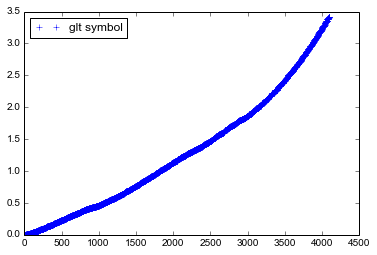

In [30]:
from gelato.expression import glt_approximate_eigenvalues
t = glt_approximate_eigenvalues(expr_a, discretization)
t.sort()
plt.plot(t, "+b", label="glt symbol")       
# ...
if with_matrix:
    # ... assembling the linear system
    form_a.assembler.assemble()
    # ...
    
    # ...
    from scipy.linalg import eig
    M = form_a.matrix.get().todense()
    w, v = eig(M)
    wr = w.real
    wr.sort()
    plt.plot(wr, "xr", label="eigenvalues")
    # ...
# ...
plt.legend(loc=2);

We plot here the approximation of the eigenvalues by a uniform sampling of the symbol of **lhs/rhs**

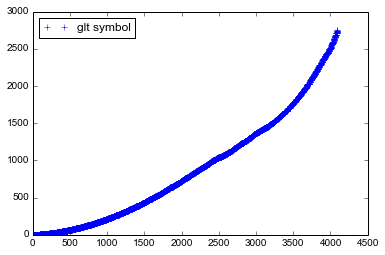

In [31]:
from gelato.expression import glt_approximate_eigenvalues
t_a = glt_approximate_eigenvalues(expr_a, discretization)
t_c = glt_approximate_eigenvalues(expr_c, discretization)
t = t_a / t_c
t = t / (4 * np.pi**2) 

t.sort()
plt.plot(t, "+b", label="glt symbol")       
# ...

if with_matrix:
    # ...
    from scipy.linalg import eig
    A = form_a.matrix.get().todense()
    C = form_c.matrix.get().todense()
    w, v = eig(A, C)
    wr = w.real
    wr.sort()
    plt.plot(wr, "xr", label="eigenvalues")
    # ...
# ...
plt.legend(loc=2);

Next, we make our symbols **callable** and then evaluate their ratio over a uniform grid.

In [32]:
# ... lambdify the glt symbol
from gelato.expression import glt_lambdify

f_a = glt_lambdify(expr_a, dim=2)
f_c = glt_lambdify(expr_c, dim=2)
# ...

# ... compute the symbol f_a / f_c
nx, ny = discretization["n_elements"]

t1 = np.linspace(-np.pi,np.pi, nx+1)
t2 = np.linspace(-np.pi,np.pi, ny+1)

u = np.linspace(0.,1.,nx+1)
v = np.linspace(0.,1.,ny+1)

x = mapping.evaluate(u,v)[0,:,:]
y = mapping.evaluate(u,v)[1,:,:]

t1, t2 = np.meshgrid(t1, t2)
t1 = np.transpose(t1)
t2 = np.transpose(t2)

f = f_a(x,y,t1,t2)/f_c(x,y,t1,t2);
f = f / (4 * np.pi**2)
# ...

let's plot their ratio 

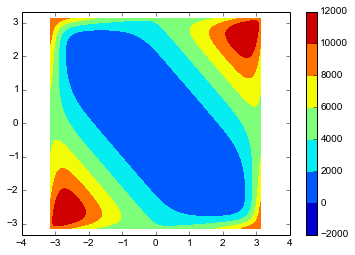

In [11]:
# ... plot
plt.contourf(t1, t2, f)
plt.axis("equal")
plt.colorbar();
# ...

Evaluation of the exact eigenvalues

In [12]:
b_1 = 1.1659397624413860850012270020670 ; b_2 = 1.0
N = discretization["n_elements"][0] ; M = discretization["n_elements"][1]
n = range(-N/2, N/2+1) 
m = range(-M/2, M/2+1)
n,m = np.meshgrid(n,m)
n = np.transpose(n)
m = np.transpose(m)
e = (b_1*n + b_2*m)**2 

Plot of the absolute error

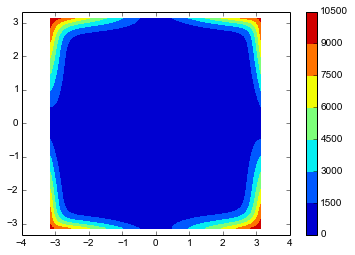

In [13]:
# ... plot
plt.contourf(t1, t2, np.abs(e-f))
plt.axis("equal")
plt.colorbar();
# ...

In [33]:
_b_1 = 1.1659397624413860850012270020670 ; _b_2 = 1.0
table = []
for i in range(-10,10+1):
    for j in range(-10,10+1):
        v = mode(i,j)
        w = (_b_1*i + _b_2*j)**2
        if v < 0.2:
            line = []
            line.append("(" + str(i) + "," + str(j) + ")")
            # approximated eigenvalue
            line.append(str(v))
            # exact eigenvalue
            line.append(str(w))
            # absolute error
            line.append(str(np.abs(v-w)))
            # relative error
            if np.abs(w) > 1.e-10:
                line.append(str(np.abs(v-w)/w))
            else:
                line.append("")
            table.append(line)
            print line

['(-7,8)', '0.0973301415151', '0.0261075590167', '0.0712225824984', '2.72804448907']
['(-6,7)', '0.0287266017545', '1.90220310983e-05', '0.0287075797234', '1509.1753123']
['(-5,6)', '0.0391930809933', '0.0290024945637', '0.0101905864295', '0.351369307462']
['(-4,5)', '0.116093429141', '0.113057976615', '0.00303545252629', '0.0268486365773']
['(-2,2)', '0.110163877056', '0.110144019036', '1.98580193572e-05', '0.000180291399669']
['(-1,1)', '0.0275363106373', '0.0275360047591', '3.05878197018e-07', '1.11082998312e-05']
['(0,0)', '1.35889180324e-14', '0.0', '1.35889180324e-14', '']
['(1,-1)', '0.0275363106373', '0.0275360047591', '3.05878197018e-07', '1.11082998312e-05']
['(2,-2)', '0.110163877056', '0.110144019036', '1.98580193572e-05', '0.000180291399669']
['(4,-5)', '0.116093429141', '0.113057976615', '0.00303545252629', '0.0268486365773']
['(5,-6)', '0.0391930809933', '0.0290024945637', '0.0101905864295', '0.351369307462']
['(6,-7)', '0.0287266017545', '1.90220310983e-05', '0.02870757

In [34]:
from tabulate import tabulate

headers = ["mode", "approximated", "exact", "absolute error", "relative error"]
print(tabulate(table, headers, tablefmt="pipe"))

| mode   |   approximated |      exact |   absolute error | relative error    |
|:-------|---------------:|-----------:|-----------------:|:------------------|
| (-7,8) |    0.0973301   | 0.0261076  |      0.0712226   | 2.72804448907     |
| (-6,7) |    0.0287266   | 1.9022e-05 |      0.0287076   | 1509.1753123      |
| (-5,6) |    0.0391931   | 0.0290025  |      0.0101906   | 0.351369307462    |
| (-4,5) |    0.116093    | 0.113058   |      0.00303545  | 0.0268486365773   |
| (-2,2) |    0.110164    | 0.110144   |      1.9858e-05  | 0.000180291399669 |
| (-1,1) |    0.0275363   | 0.027536   |      3.05878e-07 | 1.11082998312e-05 |
| (0,0)  |    1.35889e-14 | 0          |      1.35889e-14 |                   |
| (1,-1) |    0.0275363   | 0.027536   |      3.05878e-07 | 1.11082998312e-05 |
| (2,-2) |    0.110164    | 0.110144   |      1.9858e-05  | 0.000180291399669 |
| (4,-5) |    0.116093    | 0.113058   |      0.00303545  | 0.0268486365773   |
| (5,-6) |    0.0391931   | 0.0290025  |

## Variable coefficients case

We consider the following variable coefficients case for the magnetic field

$$
 \mathbf{b}(\theta, \varphi) = 
 \begin{pmatrix}
 \iota (1 + 0.1 \sin(2 \pi \varphi))
 \\
 (1 + 0.1 \sin(2 \pi \varphi))
 \end{pmatrix}
$$

### Cubic B-Splines

Convergence over a grid $128 \times 128$

| mode   |   approximated |
|:-------|---------------:|
| (-8,9) |    0.0913556   |
| (-7,8) |    0.0225571   |
| (-6,7) |    2.02803e-05 |
| (-5,6) |    0.0258704   |
| (-4,5) |    0.10265     |
| (-2,2) |    0.105888    |
| (-1,1) |    0.0269989   |
| (0,0)  |   -5.77529e-14 |
| (1,-1) |    0.0280785   |
| (2,-2) |    0.114484    |
| (4,-5) |    0.123968    |
| (5,-6) |    0.0323158   |
| (6,-7) |    2.61473e-05 |
| (7,-8) |    0.0299451   |
| (8,-9) |    0.124534    |

Convergence over a grid $256 \times 256$

| mode   |   approximated |
|:-------|---------------:|
| (-8,9) |    0.098292    |
| (-7,8) |    0.0241478   |
| (-6,7) |    1.78176e-05 |
| (-5,6) |    0.0273432   |
| (-4,5) |    0.107631    |
| (-2,2) |    0.107995    |
| (-1,1) |    0.0272664   |
| (0,0)  |   -2.31012e-13 |
| (1,-1) |    0.0278069   |
| (2,-2) |    0.112314    |
| (4,-5) |    0.118619    |
| (5,-6) |    0.0307107   |
| (6,-7) |    2.0389e-05  |
| (7,-8) |    0.0281442   |
| (8,-9) |    0.116637    |

Convergence over a grid $512 \times 512$

| mode   |   approximated |
|:-------|---------------:|
| (-8,9) |    0.102619    |
| (-7,8) |    0.0250988   |
| (-6,7) |    1.83781e-05 |
| (-5,6) |    0.0281576   |
| (-4,5) |    0.110307    |
| (-2,2) |    0.109066    |
| (-1,1) |    0.027401    |
| (0,0)  |   -9.24046e-13 |
| (1,-1) |    0.0276713   |
| (2,-2) |    0.111228    |
| (4,-5) |    0.115843    |
| (5,-6) |    0.0298598   |
| (6,-7) |    1.9679e-05  |
| (7,-8) |    0.0271362   |
| (8,-9) |    0.11202     |

Convergence over a grid $1024 \times 1024$

| mode   |   approximated |
|:-------|---------------:|
| (-8,9) |    0.104916    |
| (-7,8) |    0.0255983   |
| (-6,7) |    1.86971e-05 |
| (-5,6) |    0.0285774   |
| (-4,5) |    0.111676    |
| (-2,2) |    0.109604    |
| (-1,1) |    0.0274685   |
| (0,0)  |   -3.69619e-12 |
| (1,-1) |    0.0276036   |
| (2,-2) |    0.110685    |
| (4,-5) |    0.114449    |
| (5,-6) |    0.0294308   |
| (6,-7) |    1.93499e-05 |
| (7,-8) |    0.0266219   |
| (8,-9) |    0.109646    |

In [15]:
# ... define a discretization
#     linear splines
#discretization = {"n_elements": [128,128], "degrees": [1,1]}
#discretization = {"n_elements": [256,256], "degrees": [1,1]}
#discretization = {"n_elements": [512,512], "degrees": [1,1]}

#     linear splines
#discretization = {"n_elements": [128,128], "degrees": [2,2]}
#discretization = {"n_elements": [256,256], "degrees": [2,2]}
#discretization = {"n_elements": [512,512], "degrees": [2,2]}

#     cubic splines
#discretization = {"n_elements": [32,32], "degrees": [3,3]}
discretization = {"n_elements": [128,128], "degrees": [3,3]}
#discretization = {"n_elements": [256,256], "degrees": [3,3]}
#discretization = {"n_elements": [512,512], "degrees": [3,3]}
#discretization = {"n_elements": [1024,1024], "degrees": [3,3]}

#     quartic splines
#discretization = {"n_elements": [32,32], "degrees": [4,4]}
#discretization = {"n_elements": [64,64], "degrees": [4,4]}
#discretization = {"n_elements": [128,128], "degrees": [4,4]}
#discretization = {"n_elements": [256,256], "degrees": [4,4]}

#     quintic splines
#discretization = {"n_elements": [128,128], "degrees": [5,5]}
#discretization = {"n_elements": [256,256], "degrees": [5,5]}
#discretization = {"n_elements": [512,512], "degrees": [5,5]}
# ...

# ...
pde = construct_pde(filename="../../glt/tests/2d/inputs/anisotropic_diffusion_2.vl", 
                    mapping=mapping, 
                    discretization=discretization)

form_a = pde["a"]
b1     = pde["b1"]
b2     = pde["b2"]

b1.set("1.1659397624413860850012270020670 * (1.0 + 0.1 * sin(2*pi*y))")
b2.set("1.0 * (1.0 + 0.1 * sin(2*pi*y))")

# ... compute the glt symbol and evaluate it
from gelato.expression import glt_symbol_from_weak_formulation

expr_a = glt_symbol_from_weak_formulation(form_a, 
                                          verbose=False, evaluate=True, 
                                          discretization=discretization)
# ...

pde_c = construct_pde(filename="../../glt/tests/2d/inputs/mass.vl", 
                    mapping=mapping, 
                    discretization=discretization)

form_c = pde_c["c"]

# ... compute the glt symbol and evaluate it
from gelato.expression import glt_symbol_from_weak_formulation

expr_c = glt_symbol_from_weak_formulation(form_c, 
                                          verbose=False, evaluate=True, 
                                          discretization=discretization)
# ...

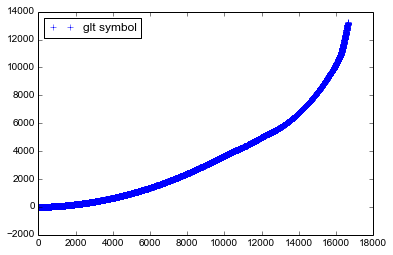

In [16]:
from gelato.expression import glt_approximate_eigenvalues
t_a = glt_approximate_eigenvalues(expr_a, discretization)
t_c = glt_approximate_eigenvalues(expr_c, discretization)
t = t_a / t_c
t = t / (4 * np.pi**2) 

t.sort()
plt.plot(t, "+b", label="glt symbol")       
# ...

if with_matrix:
    # ...
    from scipy.linalg import eig
    A = form_a.matrix.get().todense()
    C = form_c.matrix.get().todense()
    w, v = eig(A, C)
    wr = w.real
    wr.sort()
    plt.plot(wr, "xr", label="eigenvalues")
    # ...
# ...
plt.legend(loc=2);

In [17]:
# ... lambdify the glt symbol
from gelato.expression import glt_lambdify

f_a = glt_lambdify(expr_a, dim=2)
f_c = glt_lambdify(expr_c, dim=2)
# ...

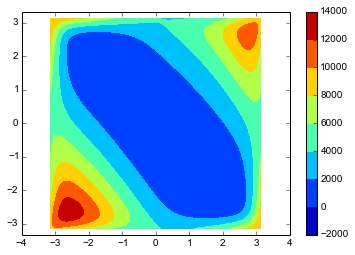

In [18]:
# ... compute the symbol f_a / f_c
nx, ny = discretization["n_elements"]

t1 = np.linspace(-np.pi,np.pi, nx+1)
t2 = np.linspace(-np.pi,np.pi, ny+1)

u = np.linspace(0.,1.,nx+1)
v = np.linspace(0.,1.,ny+1)

x = mapping.evaluate(u,v)[0,:,:]
y = mapping.evaluate(u,v)[1,:,:]

t1, t2 = np.meshgrid(t1, t2)

f = f_a(x,y,t1,t2)/f_c(x,y,t1,t2);
f = f / (4 * np.pi**2)
# ...

# ... plot
plt.contourf(t1, t2, f)
plt.axis("equal")
plt.colorbar();
# ...

In [19]:
table = []
for i in range(-10,10+1):
    for j in range(-10,10+1):
        v = mode(i,j)
        if v < 0.2:
            line = []
            line.append("(" + str(i) + "," + str(j) + ")")
            # approximated eigenvalue
            line.append(str(v))
            table.append(line)
            print line

['(-8,9)', '0.0913555855294']
['(-7,8)', '0.0225570761607']
['(-6,7)', '2.02802612761e-05']
['(-5,6)', '0.0258704075977']
['(-4,5)', '0.102650387633']
['(-2,2)', '0.105888333953']
['(-1,1)', '0.0269988501554']
['(0,0)', '-5.77529016375e-14']
['(1,-1)', '0.0280784503325']
['(2,-2)', '0.114483546832']
['(4,-5)', '0.12396849608']
['(5,-6)', '0.0323158205643']
['(6,-7)', '2.61473179239e-05']
['(7,-8)', '0.0299450594705']
['(8,-9)', '0.124534365053']


In [20]:
from tabulate import tabulate

headers = ["mode", "approximated", "exact", "absolute error", "relative error"]
print(tabulate(table, headers, tablefmt="pipe"))

| mode   |   approximated |
|:-------|---------------:|
| (-8,9) |    0.0913556   |
| (-7,8) |    0.0225571   |
| (-6,7) |    2.02803e-05 |
| (-5,6) |    0.0258704   |
| (-4,5) |    0.10265     |
| (-2,2) |    0.105888    |
| (-1,1) |    0.0269989   |
| (0,0)  |   -5.77529e-14 |
| (1,-1) |    0.0280785   |
| (2,-2) |    0.114484    |
| (4,-5) |    0.123968    |
| (5,-6) |    0.0323158   |
| (6,-7) |    2.61473e-05 |
| (7,-8) |    0.0299451   |
| (8,-9) |    0.124534    |


In [21]:
# ... Finalizing Clapp
clapp_utils.finalize()
# ...